**Problem Description**

**Competition Description from Kaggle**

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.
...
In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running.

In [ ]:
#nltk.download('punkt')        
#nltk.download('stopwords')    
#nltk.download('punkt_tab')    

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gragg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gragg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\gragg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
#spacy.cli.download("en_core_web_sm")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
import pickle
import itertools
from tensorflow.keras.metrics import Precision, Recall
import numpy as np
from sklearn.metrics import f1_score

nlp = spacy.load("en_core_web_sm")

**EDA**

First step is to look at some of the basic characteristics of the data. Given we're all working with the same files, I'll avoid overexplaing it in text and simply show some of the things I'm looking at over the next few cells.

In [30]:
#Loading in the training dataset
df = pd.read_csv('train.csv')

df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


**Checking Class Balance**

One thing I definitely want to now before embarking on model building is whether or not the target variable is imbalanced. If it is, I will need to keep that in mind when deciding which metrics to use for evaluation later. 

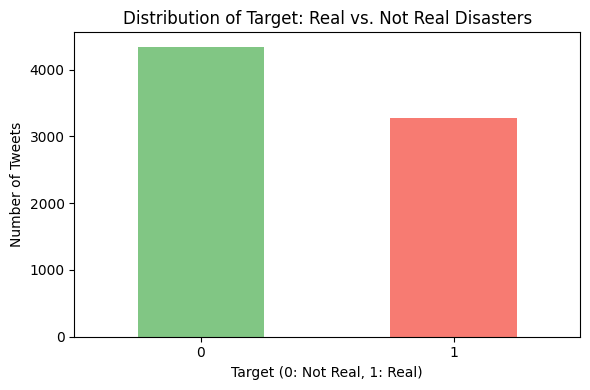

In [7]:
#Plot target variable
plt.figure(figsize=(6, 4))
df['target'].value_counts().plot(kind='bar', color=['#4CAF50', '#F44336'], alpha=0.7)

plt.title('Distribution of Target: Real vs. Not Real Disasters')
plt.xlabel('Target (0: Not Real, 1: Real)')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

**Further EDA and Data Cleaning**

Now that we have the data loaded in and some basic EDA, we need to look at any potential cleaning. I start with scoping out the missing values. We know from df.info() there are some in keywords, and locations. 

In [32]:
#EDA

#See total and percent of missing values
missing = df.isnull().sum()
percent_missing = (missing / len(df)) * 100

missing_summary = pd.DataFrame({
    'Missing Values': missing,
    'Percent Missing': percent_missing.round(2)
})

total = len(df)

missing_keyword = missing_summary.loc['keyword', 'Missing Values']
missing_location = missing_summary.loc['location', 'Missing Values']

present_keyword = total - missing_keyword
present_location = total - missing_location

keyword_counts = [present_keyword, missing_keyword]
location_counts = [present_location, missing_location]

Using some donut charts here because donut>pie and it is better for visualizing heavily imbalanced classes as we have below compared to a bar chart

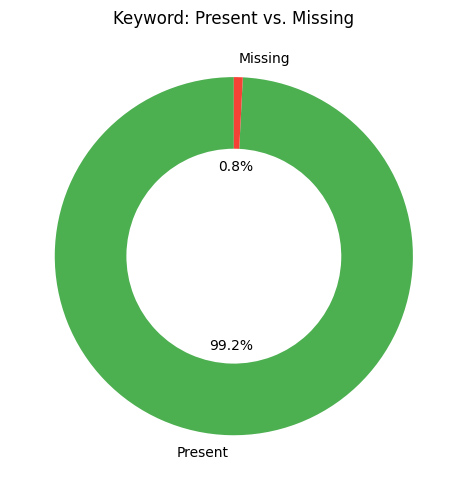

In [9]:
#Donut chart of Keyword - checking for missing values
labels = ['Present', 'Missing']
colors = ['#4CAF50', '#F44336']

plt.figure(figsize=(5, 5))
plt.pie(
    keyword_counts,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'width': 0.4},
    labeldistance=1.1,     
    pctdistance=0.5  
)
plt.title('Keyword: Present vs. Missing')
plt.tight_layout()
plt.show()

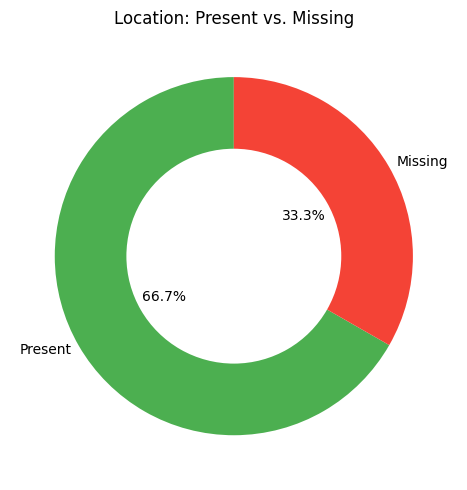

In [10]:
#Donut chart of Location - checking for missing values
plt.figure(figsize=(5, 5))
plt.pie(
    location_counts,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'width': 0.4},
    labeldistance=1.05,     
    pctdistance=0.45
)
plt.title('Location: Present vs. Missing')
plt.tight_layout()
plt.show()

In [11]:
#Data Cleaning

#Clean up nulls
df['keyword'] = df['keyword'].fillna('')
df['location'] = df['location'].fillna('')

#clean casing, special symbols
df['cleaned_text'] = df['text'].str.lower().str.replace(r'http\S+', '').str.replace(r'[^\w\s]', '')

df.head()

,id,keyword,location,text,target,cleaned_text
0,1,,,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...
1,4,,,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,5,,,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...
3,6,,,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...


In [12]:
#checking for duplicate (spam) tweets
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
#yay, no duplicates! Nothing further needed here.

Number of duplicate rows: 0


In [13]:
nltk.data.path.append('C:/Users/gragg/nltk_data')

**Tokenization**

Now that the cleaning is done we need to break down the text into something the model can process one piece (token) at a time. In this case that will be one work at a time. Since RNNs maintain a hidden state across tokens, tokenization preserves word order, allowing the model to learn context and meaning over time.

In [14]:
#Tokenization using NLTK
df['tokens'] = df['cleaned_text'].apply(nltk.word_tokenize)

#Remove stopwords
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

#Lemmatization using spaCy
nlp = spacy.load('en_core_web_sm')
df['tokens'] = df['cleaned_text'].apply(lambda x: [token.lemma_ for token in nlp(x) if not token.is_stop])

# View the first few rows of tokenized text
print(df['tokens'].head())

0        [deed, reason, #, earthquake, allah, forgive]
1     [forest, fire, near, la, ronge, sask, ., canada]
2    [resident, ask, ', shelter, place, ', notify, ...
3    [13,000, people, receive, #, wildfire, evacuat...
4    [get, send, photo, ruby, #, alaska, smoke, #, ...
Name: tokens, dtype: object


I see a lot of symbols in the cleaned text that didn't get removed over since they were attached to words. It makes since that we would see a lot of hastags and apostrophes as tokens for this reason. Still, we're going to clean them all up. When I redo this project I might play with keeping the hashtag as that could indicate some information for the model. 

In [15]:
def clean_tokens(text):
    doc = nlp(text)
    return [
        token.lemma_.lower() 
        for token in doc 
        if token.is_alpha and not token.is_stop
    ]

In [16]:
df['clean_tokens'] = df['cleaned_text'].apply(clean_tokens)

In [17]:
df.head()

,id,keyword,location,text,target,cleaned_text,tokens,clean_tokens
0,1,,,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...,"[deed, reason, #, earthquake, allah, forgive]","[deed, reason, earthquake, allah, forgive]"
1,4,,,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada,"[forest, fire, near, la, ronge, sask, ., canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,,,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...,"[resident, ask, ', shelter, place, ', notify, ...","[resident, ask, shelter, place, notify, office..."
3,6,,,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...","[13,000, people, receive, #, wildfire, evacuat...","[people, receive, wildfire, evacuation, order,..."
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...,"[get, send, photo, ruby, #, alaska, smoke, #, ...","[get, send, photo, ruby, alaska, smoke, wildfi..."


In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_tokens'])

sequences = tokenizer.texts_to_sequences(df['clean_tokens'])

vocab_size = len(tokenizer.word_index) + 1 

In [19]:
max_len = 30 #It doesn't look like we have any above this anyway.
x_train = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

**Model building time!**

We'll tune the parameters later, but adam should be a good optimizer, and binary_crossentropy will work best as this is a classification project with only two possible outputs. I also know I want to look at F1 score during training and parameter tuning, so I'm including precision and recall as metrics.

We chose GRU (Gated Recurrent Unit) because it’s a simplified version of LSTM that still captures long-term dependencies in sequences. GRUs are faster to train and require fewer resources, making them a good fit for our binary classification task. They perform well on text data without being as complex as LSTMs.

In [33]:
def build_model(vocab_size, 
                embedding_dim=128, gru_units=64, 
                optimizer='adam', loss='binary_crossentropy'):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
    model.add(GRU(gru_units, return_sequences=False))
    model.add(Dense(1, activation='sigmoid')) 

    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=['accuracy', Precision(), Recall()]
    )
    return model

**Parameter Tuning**

This is a fairly simple loop that will test out every combination of metrics I have listed here at the top of the next cell. I tried to include the full range of reasonable values without spending too long cycling through paramters I know won't be an improvement, such as a different loss function. 

Forgive the ugly visualizations below, but these will help when keeping an eye out for overfitting, or seeing when the model is getting stuck or unstuck from a local minimum. 

Training with: Embedding=50, GRU=32, Optimizer=adam, Loss=binary_crossentropy
Epoch 1/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5781 - loss: 0.6830 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.7018 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5765 - loss: 0.6824 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.6971 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5973 - loss: 0.6633 - precision: 0.3302 - recall: 0.0645 - val_accuracy: 0.7748 - val_loss: 0.4902 - val_precision: 0.9178 - val_recall: 0.5670
Epoch 4/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8597 - loss: 0.3522 - precision: 0.8874 - recall: 0.7565 - val_accuracy: 0.7846 - val_loss: 0.4588 - val_precision: 0.7757 - val_recall: 0.7560


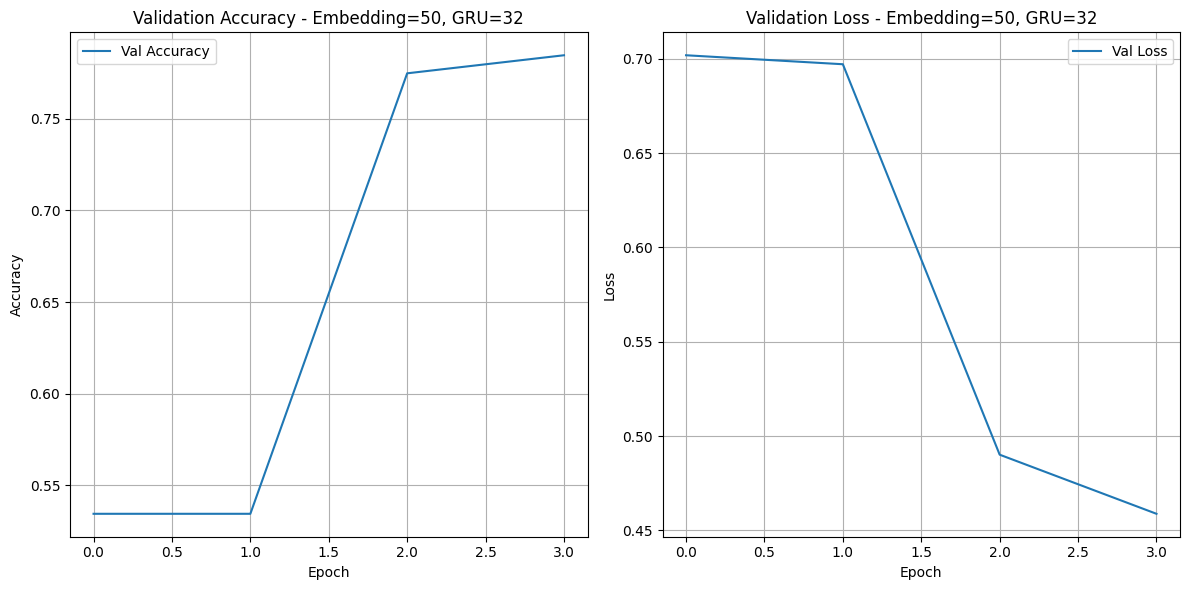

Training with: Embedding=50, GRU=50, Optimizer=adam, Loss=binary_crossentropy
Epoch 1/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5757 - loss: 0.6848 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.6937 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5865 - loss: 0.6788 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.6916 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5852 - loss: 0.6800 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.6952 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6375 - loss: 0.6239 - precision_1: 0.5407 - recall_1: 0.1997 - val_accuracy: 0.8043 - val_loss: 0.4430 - val_precision_1: 0.8465 - val_recall_1: 0.7080


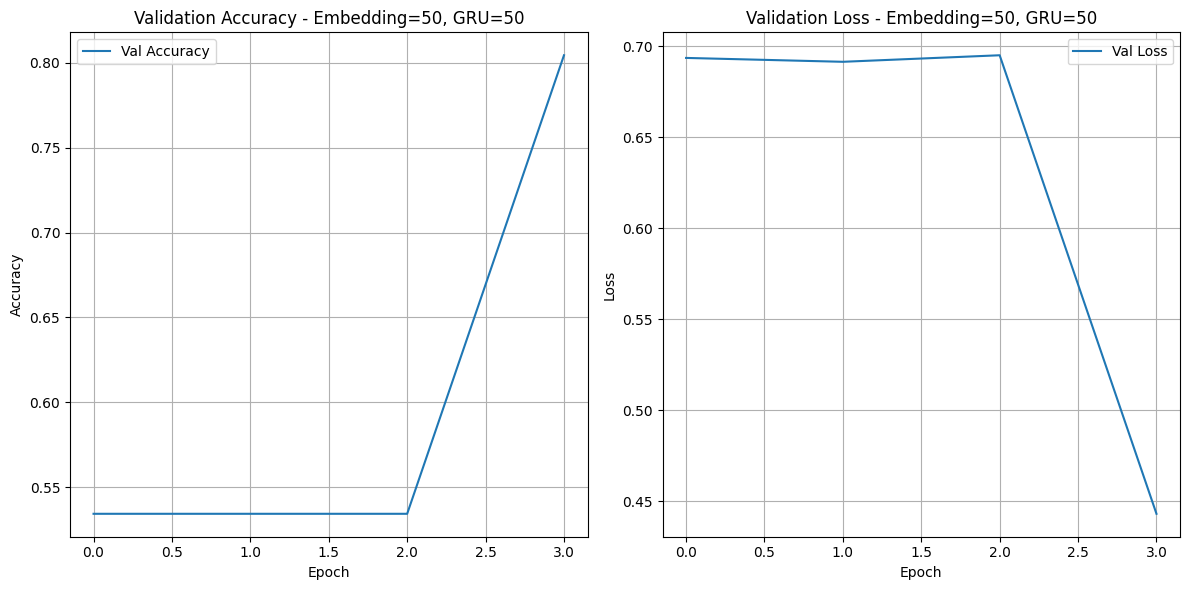

Training with: Embedding=50, GRU=75, Optimizer=adam, Loss=binary_crossentropy
Epoch 1/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5835 - loss: 0.6822 - precision_2: 0.4062 - recall_2: 0.0308 - val_accuracy: 0.5345 - val_loss: 0.6918 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5840 - loss: 0.6798 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.6940 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5914 - loss: 0.6767 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.6909 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5888 - loss: 0.6791 - precision_2: 0.0538 - recall_2: 0.0010 - val_accuracy: 0.7006 - val_loss: 0.6130 - val_precision_2: 0.9534 - val_recall_2: 0.3752


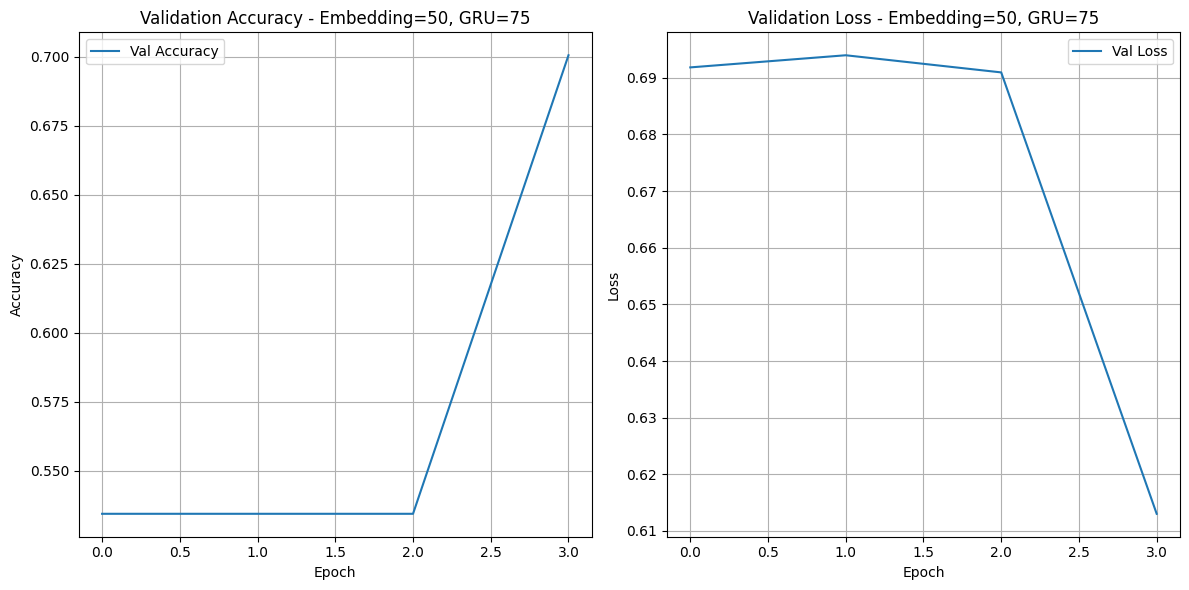

Training with: Embedding=50, GRU=100, Optimizer=adam, Loss=binary_crossentropy
Epoch 1/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5828 - loss: 0.6812 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.6920 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5848 - loss: 0.6800 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.6941 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5829 - loss: 0.6797 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.6937 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 4/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5766 - loss: 0.6820 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.6963 - val_precision_3: 0.0000e+00 - val_recall

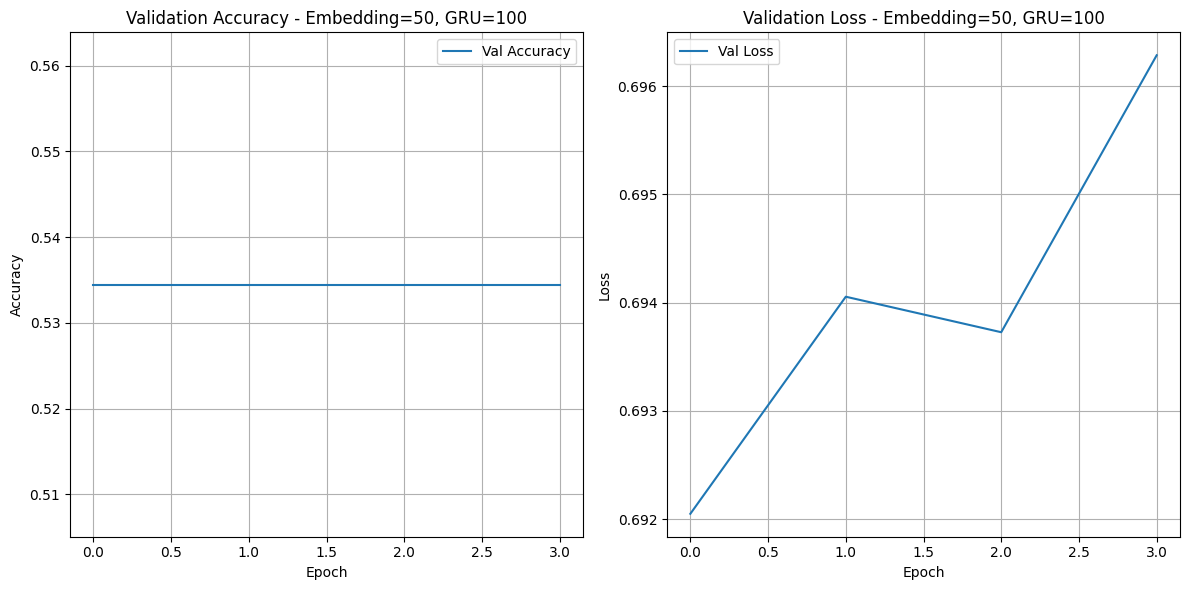

Training with: Embedding=100, GRU=32, Optimizer=adam, Loss=binary_crossentropy
Epoch 1/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5793 - loss: 0.6826 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.6912 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 2/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5826 - loss: 0.6802 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.6935 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 3/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5997 - loss: 0.6670 - precision_4: 0.2895 - recall_4: 0.0458 - val_accuracy: 0.7919 - val_loss: 0.4642 - val_precision_4: 0.8161 - val_recall_4: 0.7137
Epoch 4/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8464 - loss: 0.3785 - precision_4: 0.8530 - recall_4: 0.7607 - val_accuracy: 0.7853 - val_loss: 0.4579 - val_precision_4: 0.7698 - val_recall_4: 0.7687


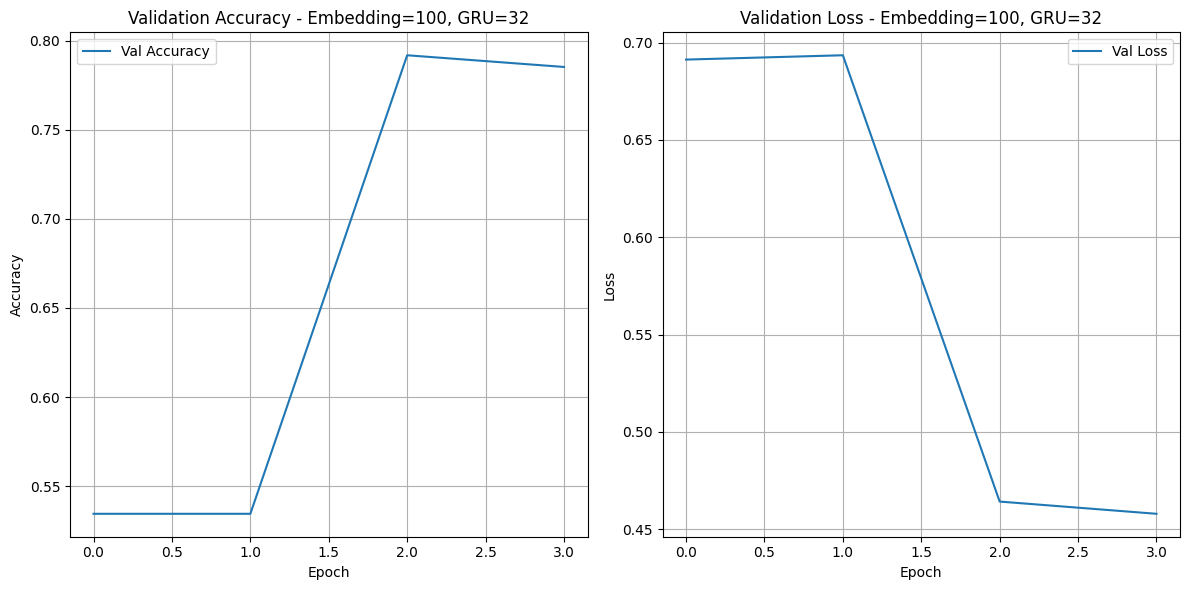

Training with: Embedding=100, GRU=50, Optimizer=adam, Loss=binary_crossentropy
Epoch 1/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5798 - loss: 0.6808 - precision_5: 0.3125 - recall_5: 0.0248 - val_accuracy: 0.5345 - val_loss: 0.6910 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 2/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5772 - loss: 0.6821 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.6929 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 3/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5790 - loss: 0.6806 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.6912 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 4/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6346 - loss: 0.6421 - precision_5: 0.4628 - recall_5: 0.1340 - val_accuracy: 0.7853 - val_loss: 0.4706 - val_precision_5: 0.8882 - val_recall_5: 0.6164


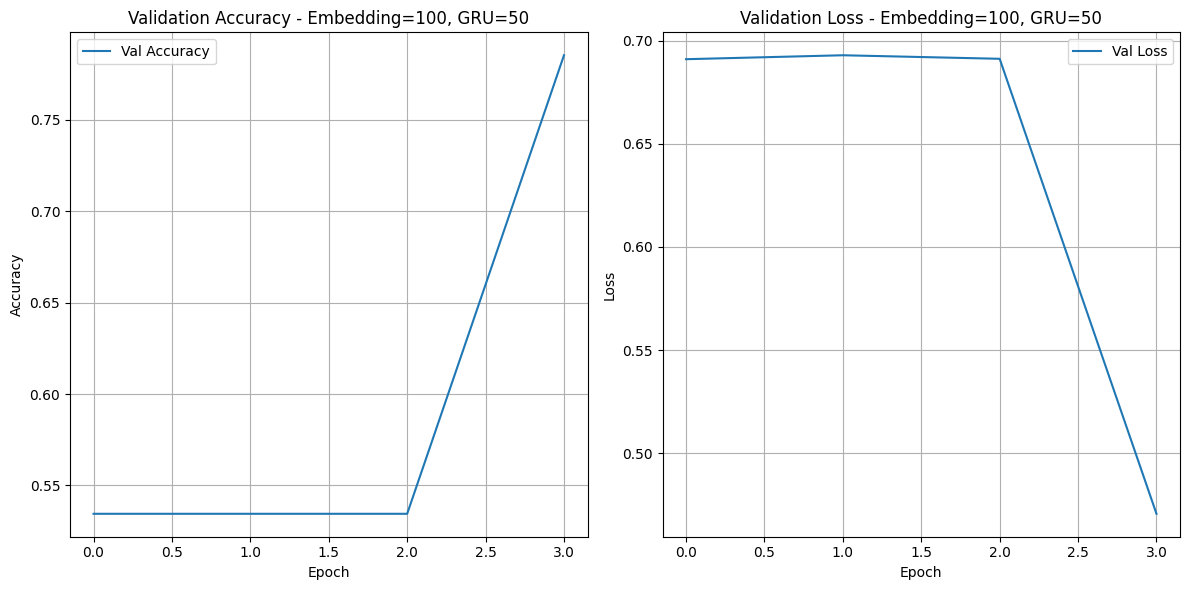

Training with: Embedding=100, GRU=75, Optimizer=adam, Loss=binary_crossentropy
Epoch 1/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5814 - loss: 0.6818 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.6941 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 2/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5897 - loss: 0.6779 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.6930 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 3/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5995 - loss: 0.6701 - precision_6: 0.2717 - recall_6: 0.0413 - val_accuracy: 0.7919 - val_loss: 0.4863 - val_precision_6: 0.8245 - val_recall_6: 0.7024
Epoch 4/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8410 - loss: 0.3894 - precision_6: 0.8422 - recall_6: 0.7649 - val_accuracy: 0.7984 - val_loss: 0.4539 - val_precision_6: 0.8141 - val_recall_6: 0.7348


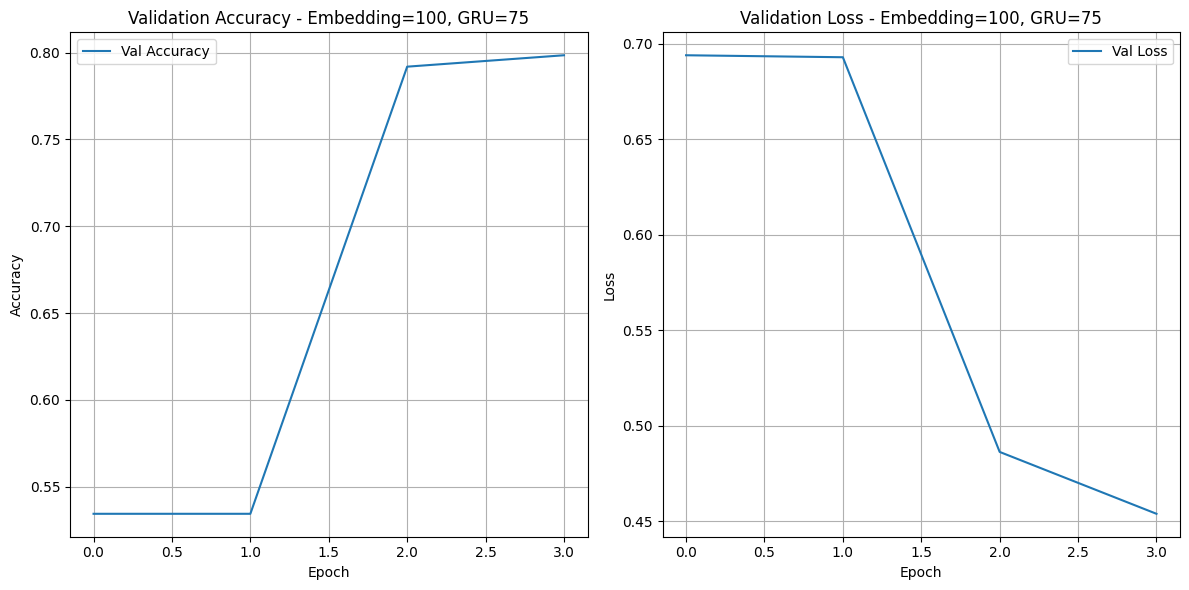

Training with: Embedding=100, GRU=100, Optimizer=adam, Loss=binary_crossentropy
Epoch 1/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5826 - loss: 0.6830 - precision_7: 0.5000 - recall_7: 0.0357 - val_accuracy: 0.5345 - val_loss: 0.6982 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 2/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5718 - loss: 0.6845 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.6987 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 3/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5892 - loss: 0.6775 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.6920 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 4/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5763 - loss: 0.6820 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.6939 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0

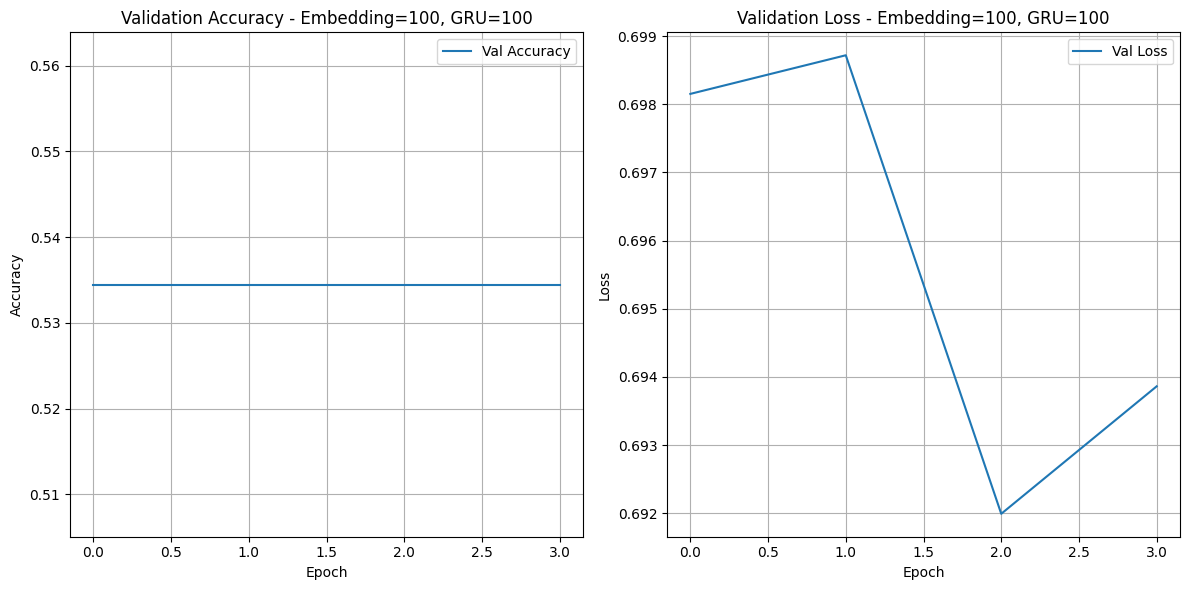

Training with: Embedding=200, GRU=32, Optimizer=adam, Loss=binary_crossentropy
Epoch 1/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.5802 - loss: 0.6815 - precision_8: 0.3750 - recall_8: 0.0281 - val_accuracy: 0.5345 - val_loss: 0.6910 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 2/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.5886 - loss: 0.6793 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.6969 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 3/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.5861 - loss: 0.6765 - precision_8: 0.1659 - recall_8: 0.0166 - val_accuracy: 0.7945 - val_loss: 0.5034 - val_precision_8: 0.8028 - val_recall_8: 0.7405
Epoch 4/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8326 - loss: 0.4011 - precision_8: 0.8433 - recall_8: 0.7450 - val_accuracy: 0.7886 - val_loss: 0.4547 - val_precision_8: 0.7722 - val_recall_8: 0.7743


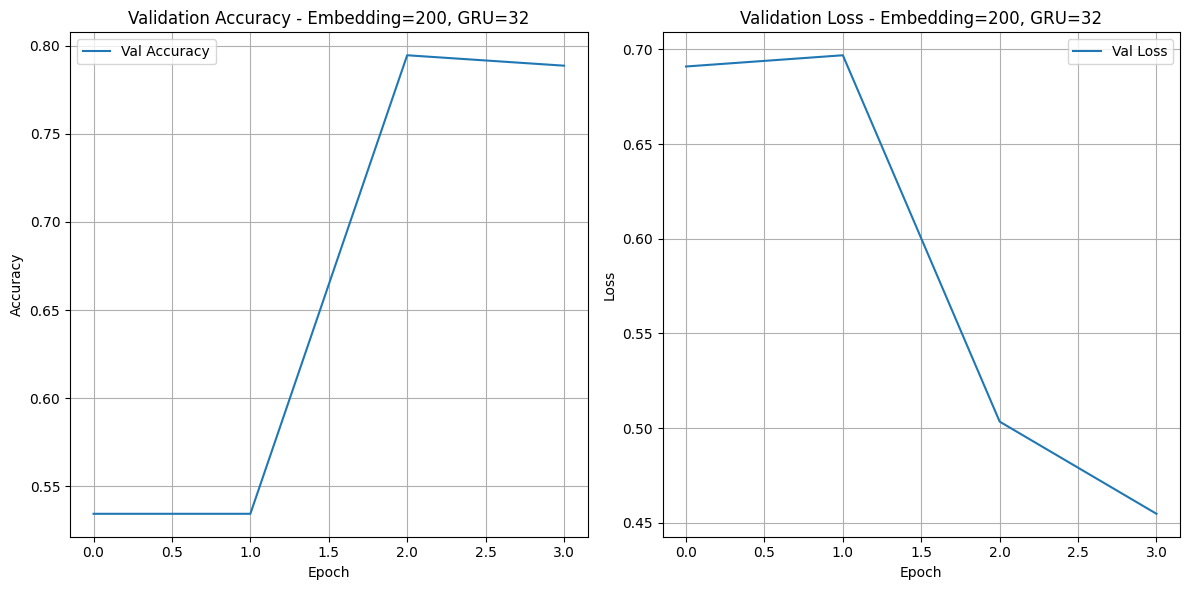

Training with: Embedding=200, GRU=50, Optimizer=adam, Loss=binary_crossentropy
Epoch 1/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.5878 - loss: 0.6824 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.6995 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 2/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.5754 - loss: 0.6834 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.6962 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 3/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.6097 - loss: 0.6547 - precision_9: 0.3894 - recall_9: 0.0957 - val_accuracy: 0.7768 - val_loss: 0.4691 - val_precision_9: 0.8176 - val_recall_9: 0.6700
Epoch 4/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8619 - loss: 0.3466 - precision_9: 0.8724 - recall_9: 0.7878 - val_accuracy: 0.8056 - val_loss: 0.4664 - val_precision_9: 0.8402 - val_recall_9: 0.7193


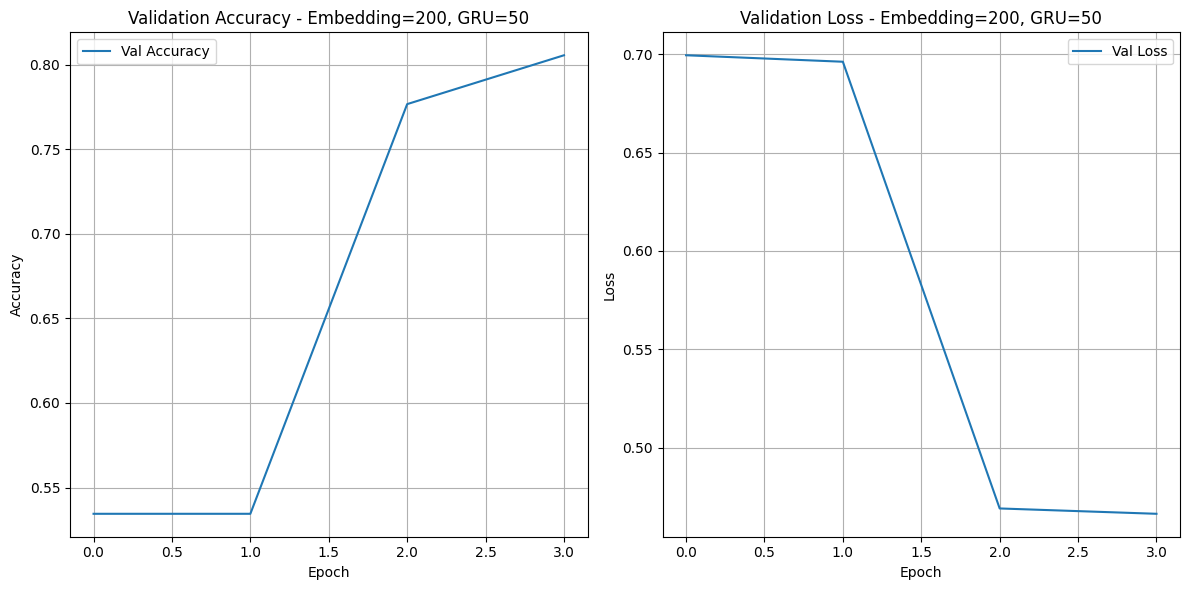

Training with: Embedding=200, GRU=75, Optimizer=adam, Loss=binary_crossentropy
Epoch 1/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.5819 - loss: 0.6799 - precision_10: 0.4375 - recall_10: 0.0309 - val_accuracy: 0.5345 - val_loss: 0.6929 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 2/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.5722 - loss: 0.6836 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.6972 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 3/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.5822 - loss: 0.6802 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.6973 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 4/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.5935 - loss: 0.6687 - precision_10: 0.2918 - recall_10: 0.0473 - val_accuracy: 0.7715 - val_loss: 0.4715 - val_precision_10: 0.8336 - val_recall_10: 

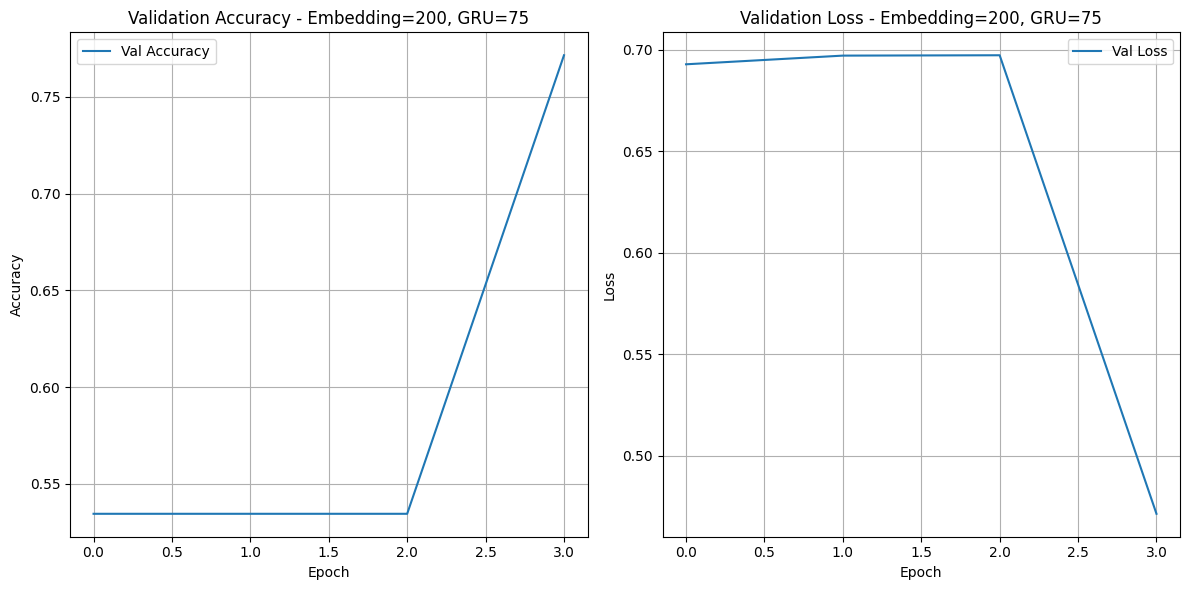

Training with: Embedding=200, GRU=100, Optimizer=adam, Loss=binary_crossentropy
Epoch 1/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.5813 - loss: 0.6796 - precision_11: 0.4062 - recall_11: 0.0303 - val_accuracy: 0.5345 - val_loss: 0.6926 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 2/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.5818 - loss: 0.6805 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.7026 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 3/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.5786 - loss: 0.6828 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.6947 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 4/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.5820 - loss: 0.6751 - precision_11: 0.2347 - recall_11: 0.0393 - val_accuracy: 0.7794 - val_loss: 0.4977 - val_precision_11: 0.8861 - val_recall_11:

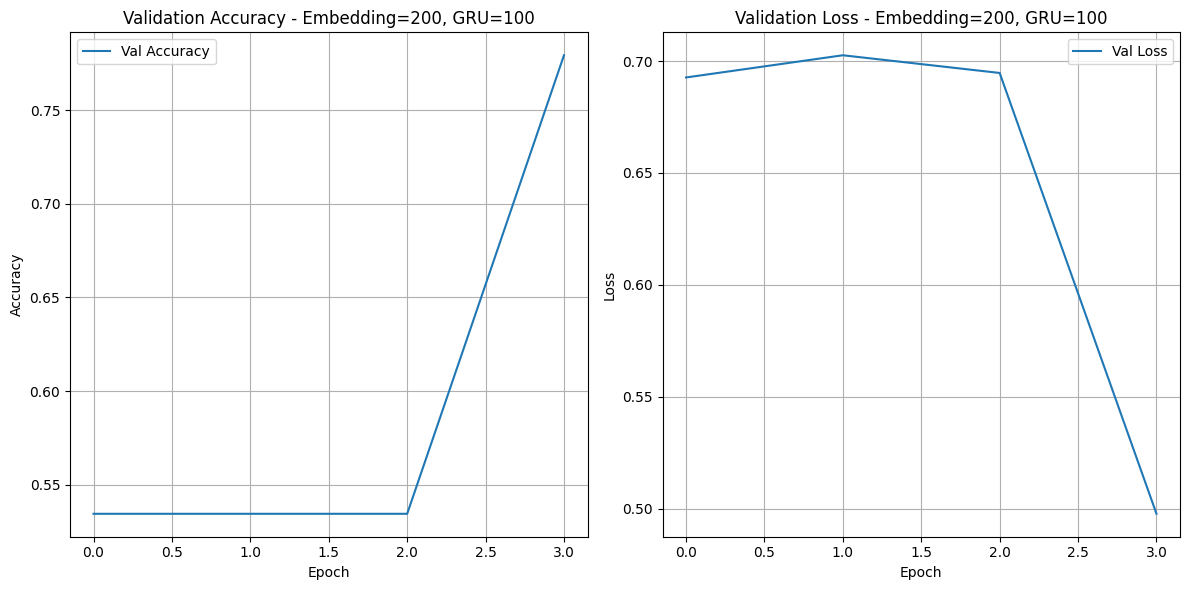

Training with: Embedding=300, GRU=32, Optimizer=adam, Loss=binary_crossentropy
Epoch 1/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.5681 - loss: 0.6840 - precision_12: 0.3438 - recall_12: 0.0262 - val_accuracy: 0.5345 - val_loss: 0.7022 - val_precision_12: 0.0000e+00 - val_recall_12: 0.0000e+00
Epoch 2/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.5835 - loss: 0.6799 - precision_12: 0.0000e+00 - recall_12: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6688 - val_precision_12: 0.9661 - val_recall_12: 0.0804
Epoch 3/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.7791 - loss: 0.4941 - precision_12: 0.8088 - recall_12: 0.6536 - val_accuracy: 0.7905 - val_loss: 0.4608 - val_precision_12: 0.8482 - val_recall_12: 0.6700
Epoch 4/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9020 - loss: 0.2599 - precision_12: 0.9196 - recall_12: 0.8403 - val_accuracy: 0.7715 - val_loss: 0.5143 - val_precision_12: 0.7590 - val_recall_12: 0.7461


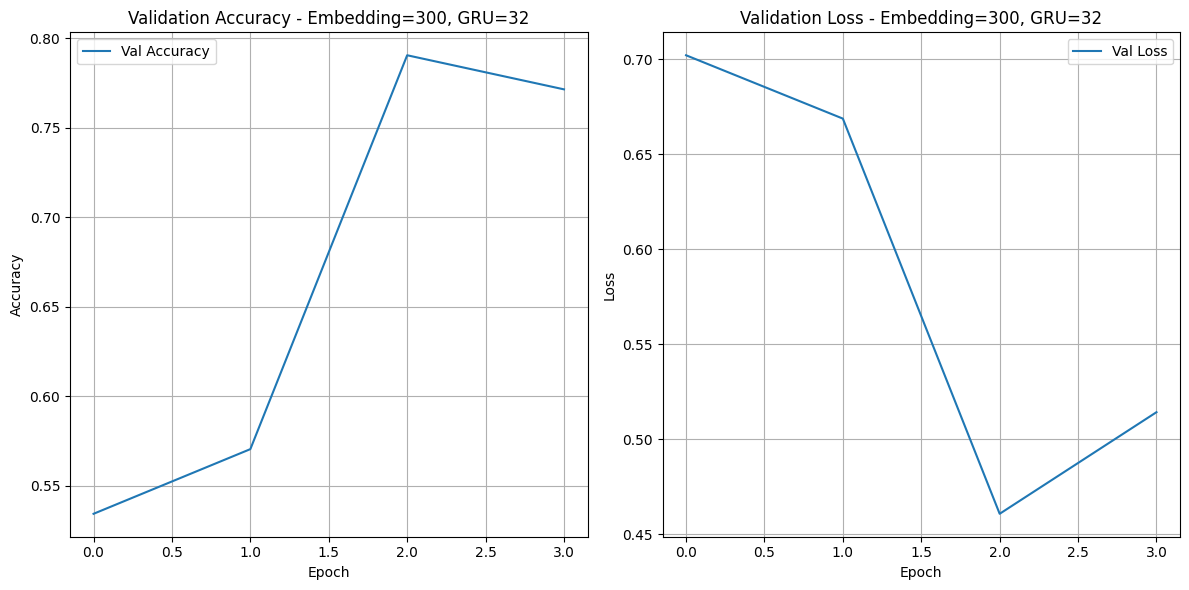

Training with: Embedding=300, GRU=50, Optimizer=adam, Loss=binary_crossentropy
Epoch 1/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.5762 - loss: 0.6845 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.7074 - val_precision_13: 0.0000e+00 - val_recall_13: 0.0000e+00
Epoch 2/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.5881 - loss: 0.6778 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.6961 - val_precision_13: 0.0000e+00 - val_recall_13: 0.0000e+00
Epoch 3/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.6524 - loss: 0.6147 - precision_13: 0.5658 - recall_13: 0.2478 - val_accuracy: 0.8004 - val_loss: 0.4551 - val_precision_13: 0.8438 - val_recall_13: 0.7010
Epoch 4/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8881 - loss: 0.2924 - precision_13: 0.9116 - recall_13: 0.8158 - val_accuracy: 0.7794 - val_loss: 0.4852 - val_precision_13: 0.7653 - val_recall_13: 0.7588


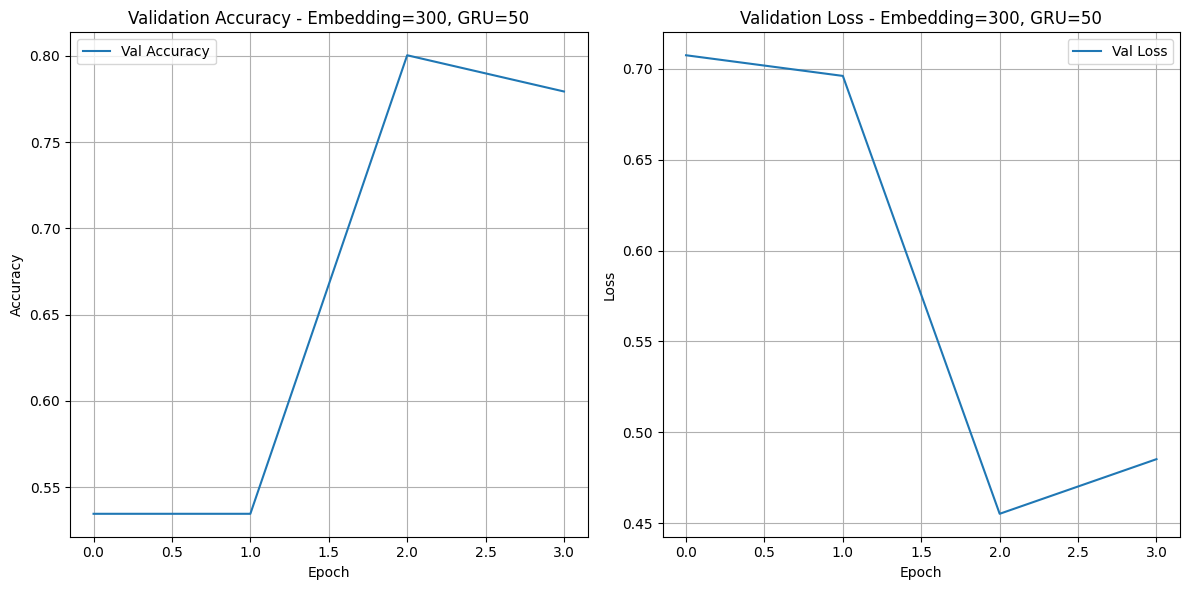

Training with: Embedding=300, GRU=75, Optimizer=adam, Loss=binary_crossentropy
Epoch 1/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.5722 - loss: 0.6820 - precision_14: 0.4384 - recall_14: 0.1035 - val_accuracy: 0.5345 - val_loss: 0.6988 - val_precision_14: 0.0000e+00 - val_recall_14: 0.0000e+00
Epoch 2/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.5790 - loss: 0.6823 - precision_14: 0.0000e+00 - recall_14: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.7013 - val_precision_14: 0.0000e+00 - val_recall_14: 0.0000e+00
Epoch 3/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.5783 - loss: 0.6823 - precision_14: 0.0206 - recall_14: 4.2761e-05 - val_accuracy: 0.7334 - val_loss: 0.6417 - val_precision_14: 0.8616 - val_recall_14: 0.5092
Epoch 4/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.7976 - loss: 0.4833 - precision_14: 0.8048 - recall_14: 0.6837 - val_accuracy: 0.7899 - val_loss: 0.4643 - val_precision_14: 0.8044 - val_recall_14: 0.7250


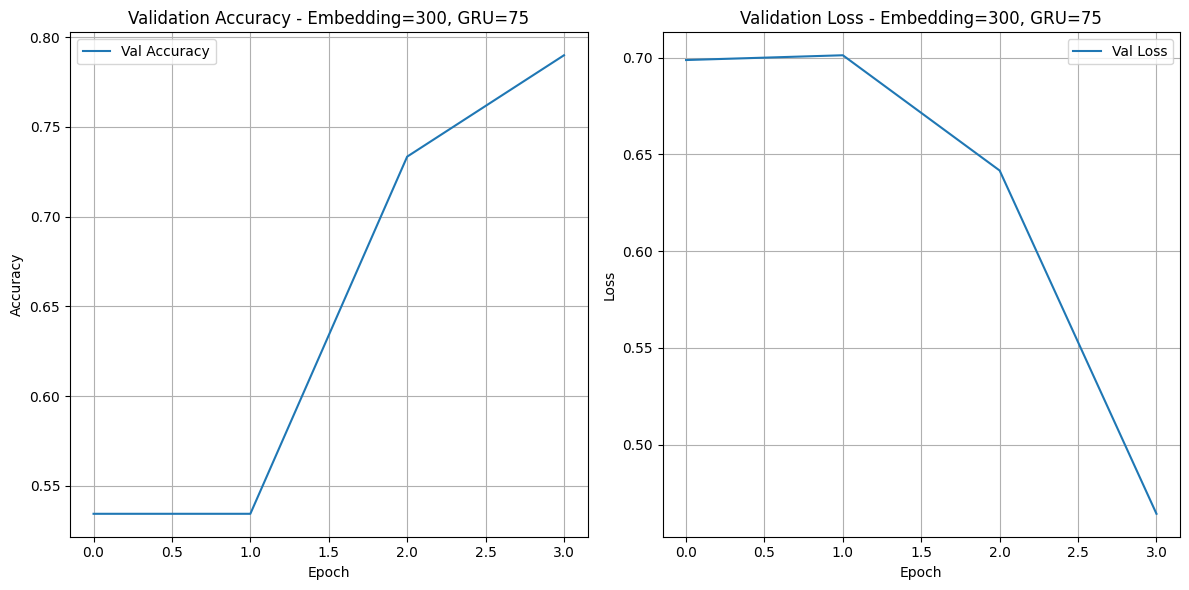

Training with: Embedding=300, GRU=100, Optimizer=adam, Loss=binary_crossentropy
Epoch 1/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.5688 - loss: 0.6837 - precision_15: 0.4355 - recall_15: 0.0485 - val_accuracy: 0.5345 - val_loss: 0.6957 - val_precision_15: 0.0000e+00 - val_recall_15: 0.0000e+00
Epoch 2/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.5803 - loss: 0.6812 - precision_15: 0.0000e+00 - recall_15: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.6963 - val_precision_15: 0.0000e+00 - val_recall_15: 0.0000e+00
Epoch 3/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.5906 - loss: 0.6779 - precision_15: 0.0000e+00 - recall_15: 0.0000e+00 - val_accuracy: 0.5345 - val_loss: 0.6942 - val_precision_15: 0.0000e+00 - val_recall_15: 0.0000e+00
Epoch 4/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.5814 - loss: 0.6787 - precision_15: 0.1508 - recall_15: 0.0141 - val_accuracy: 0.7643 - val_loss: 0.5116 - val_precision_15: 0.7358 - val_recall_15

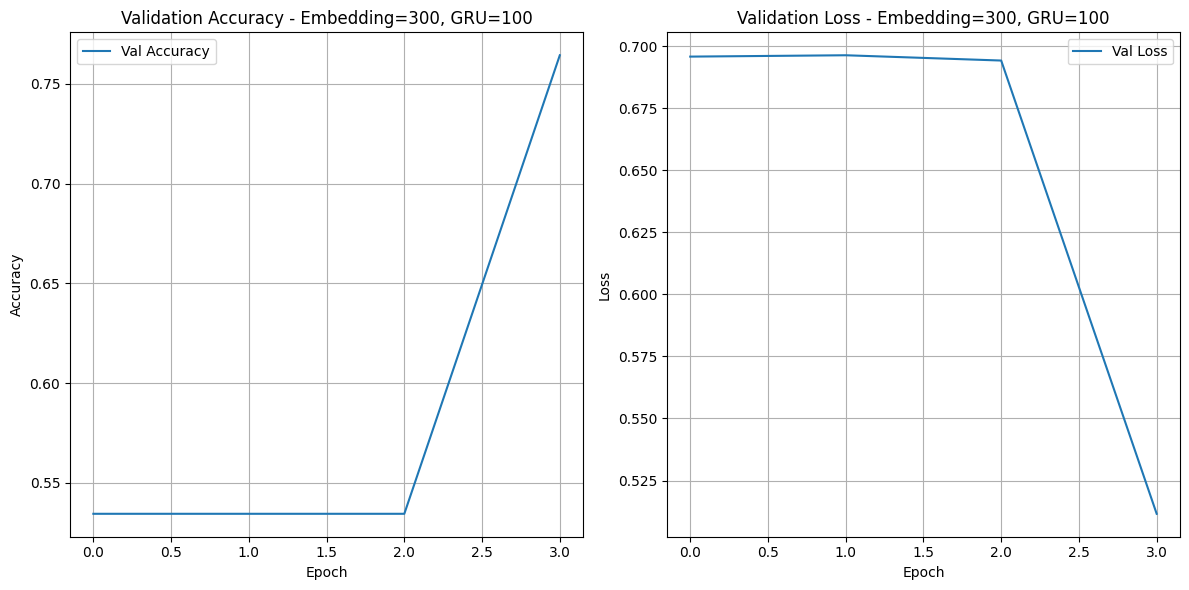

{'embedding': 50, 'gru': 32, 'optimizer': 'adam', 'accuracy': 0.784635603427887, 'loss': 0.4588336944580078}
{'embedding': 50, 'gru': 50, 'optimizer': 'adam', 'accuracy': 0.8043335676193237, 'loss': 0.4429904520511627}
{'embedding': 50, 'gru': 75, 'optimizer': 'adam', 'accuracy': 0.700590968132019, 'loss': 0.6130272150039673}
{'embedding': 50, 'gru': 100, 'optimizer': 'adam', 'accuracy': 0.5344714522361755, 'loss': 0.6962844729423523}
{'embedding': 100, 'gru': 32, 'optimizer': 'adam', 'accuracy': 0.7852922081947327, 'loss': 0.4579179584980011}
{'embedding': 100, 'gru': 50, 'optimizer': 'adam', 'accuracy': 0.7852922081947327, 'loss': 0.4706220030784607}
{'embedding': 100, 'gru': 75, 'optimizer': 'adam', 'accuracy': 0.7984241843223572, 'loss': 0.4538564682006836}
{'embedding': 100, 'gru': 100, 'optimizer': 'adam', 'accuracy': 0.5344714522361755, 'loss': 0.6938623189926147}
{'embedding': 200, 'gru': 32, 'optimizer': 'adam', 'accuracy': 0.7885751724243164, 'loss': 0.4546974003314972}
{'emb

In [21]:
embedding_dims = [50, 100, 200, 300]
gru_units_list = [32, 50, 75, 100]
optimizers = ['adam']
loss_functions = ['binary_crossentropy']

# Results dictionary to store metrics
results = []

for embedding_dim in embedding_dims:
    for gru_units in gru_units_list:
        for optimizer in optimizers:
            for loss in loss_functions:
                print(f"Training with: Embedding={embedding_dim}, GRU={gru_units}, Optimizer={optimizer}, Loss={loss}")

                model = build_model(
                    vocab_size=len(tokenizer.word_index) + 1,
                    embedding_dim=embedding_dim,
                    gru_units=gru_units,
                    optimizer=optimizer,
                    loss=loss
                )

                # Perform training with a validation split
                history = model.fit(
                    x_train,
                    y_train,
                    epochs=4,
                    batch_size=32,
                    verbose=1,
                    validation_split=0.2  # 20% of the training data will be used for validation
                )

                # Store the results in a dictionary for plotting later
                results.append({
                    'embedding': embedding_dim,
                    'gru': gru_units,
                    'optimizer': optimizer,
                    'accuracy': history.history['val_accuracy'][-1],  # Accuracy on validation set
                    'loss': history.history['val_loss'][-1]  # Loss on validation set
                })

                # Plotting the accuracy and loss for the current run
                plt.figure(figsize=(12, 6))

                # Plot accuracy over epochs
                plt.subplot(1, 2, 1)
                plt.plot(history.history['val_accuracy'], label='Val Accuracy')
                plt.title(f'Validation Accuracy - Embedding={embedding_dim}, GRU={gru_units}')
                plt.xlabel('Epoch')
                plt.ylabel('Accuracy')
                plt.legend()
                plt.grid(True)

                # Plot loss over epochs
                plt.subplot(1, 2, 2)
                plt.plot(history.history['val_loss'], label='Val Loss')
                plt.title(f'Validation Loss - Embedding={embedding_dim}, GRU={gru_units}')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()
                plt.grid(True)

                plt.tight_layout()
                plt.show()

# After all experiments, you can analyze the results
for result in results:
    print(result)

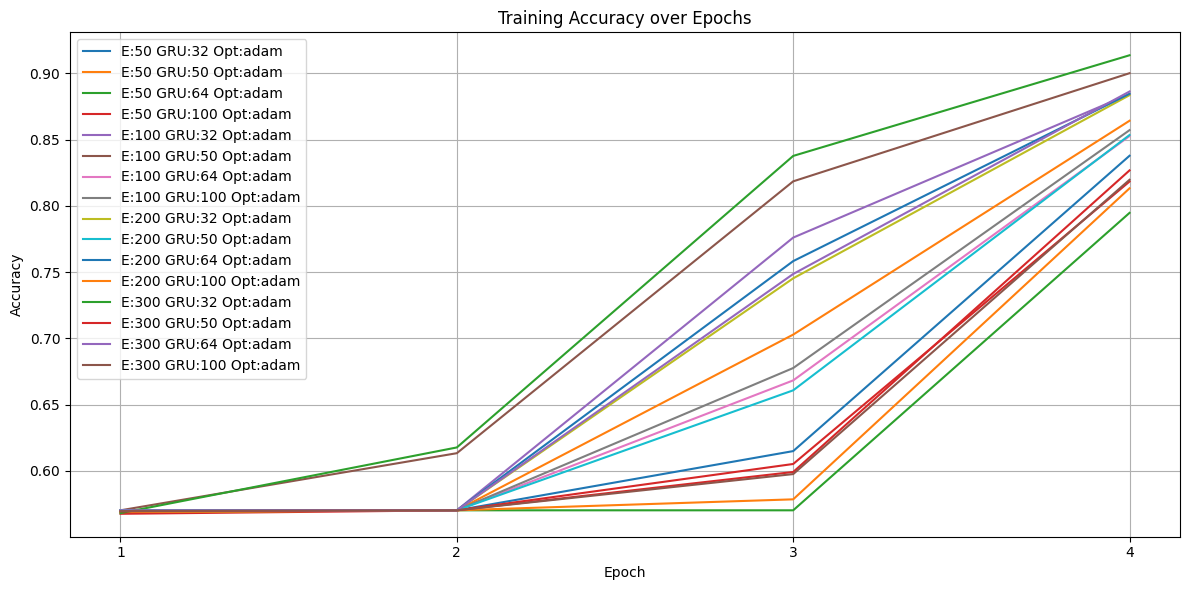

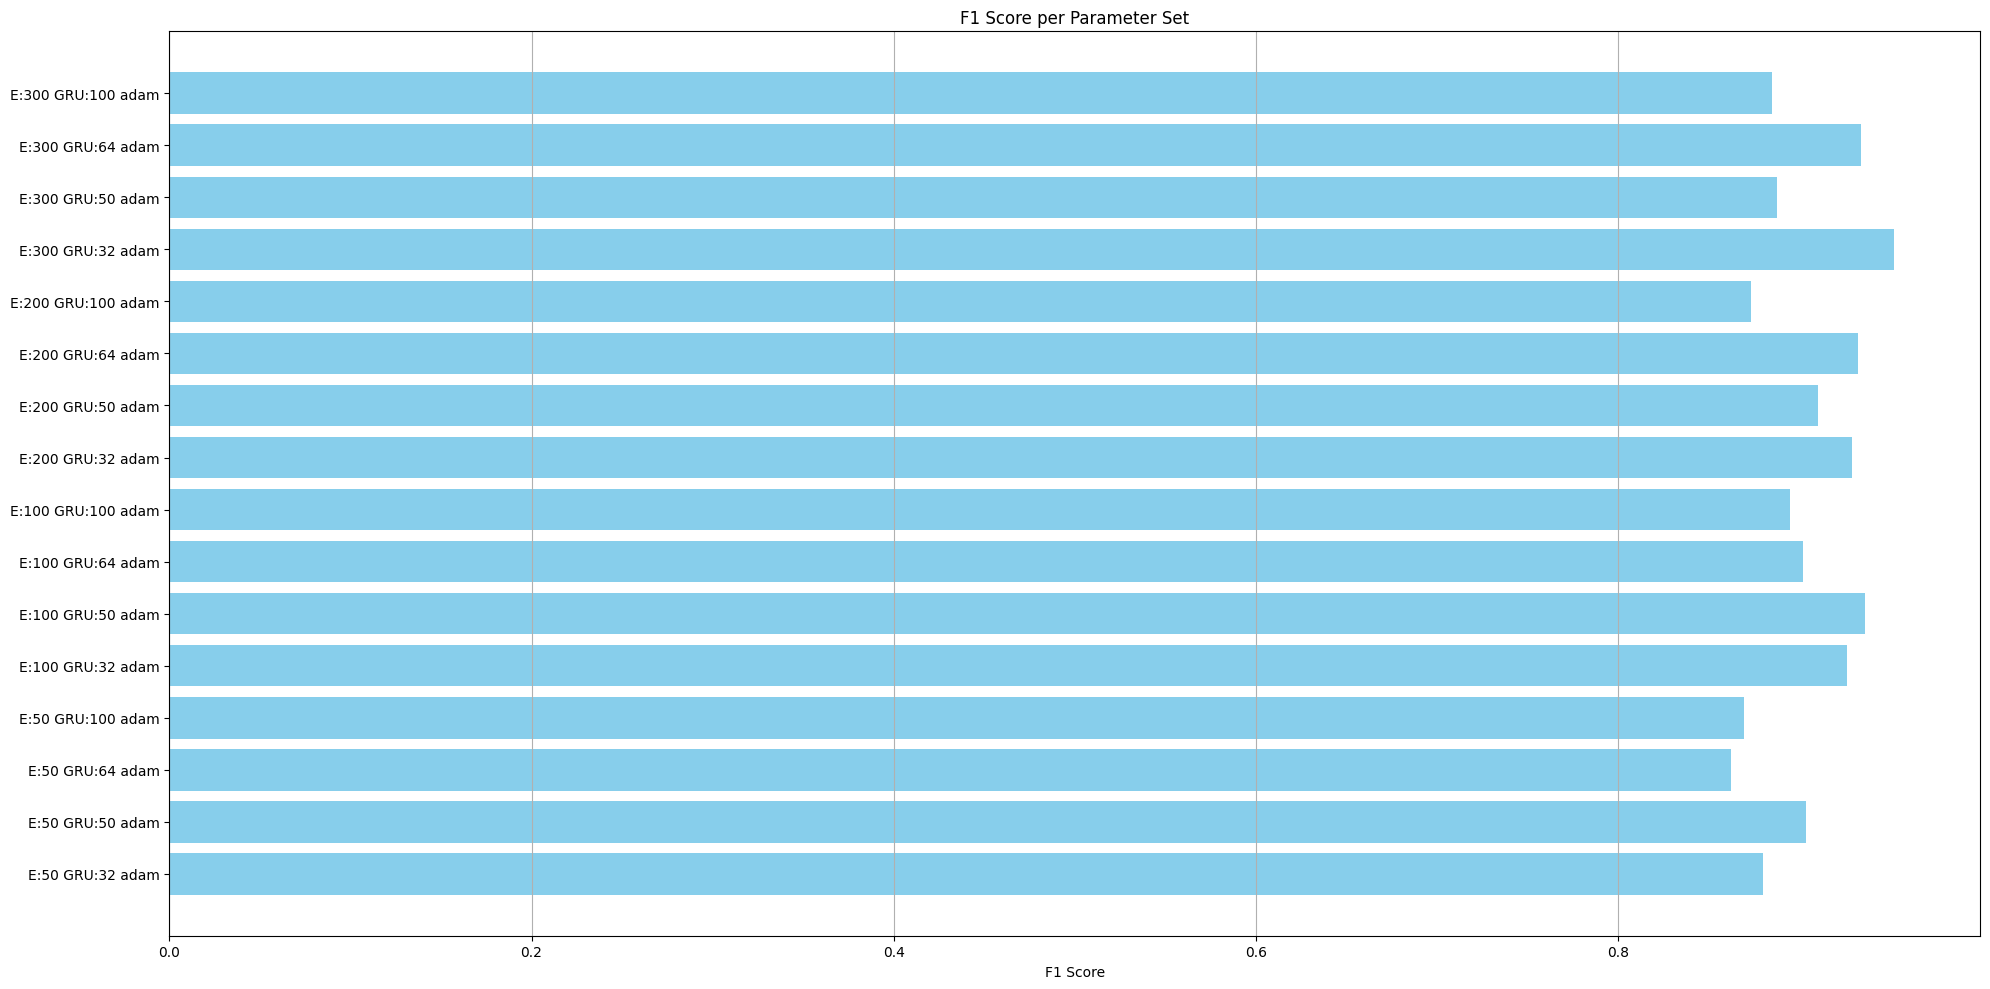

In [46]:
plt.figure(figsize=(12, 6))
for result in results:
    label = f"E:{result['embedding']} GRU:{result['gru']} Opt:{result['optimizer']}"
    plt.plot(result['accuracy'], label=label)

plt.title("Training Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Set x-ticks to whole numbers only
epochs = range(len(results[0]['accuracy']))  # assumes all runs have same number of epochs
plt.xticks(epochs, [str(e+1) for e in epochs])  # display epoch numbers starting from 1

plt.tight_layout()
plt.show()

# Plot F1 scores for comparison
plt.figure(figsize=(20, 10))
labels = [f"E:{r['embedding']} GRU:{r['gru']} {r['optimizer']}" for r in results]
f1_scores = [r['f1'] for r in results]
plt.barh(labels, f1_scores, color='skyblue')
plt.title("F1 Score per Parameter Set")
plt.xlabel("F1 Score")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


**Test Dataset Prediction**

Now we'll run the model on the test dataset based on parameter tuning. I'm running for 8 epochs which should be enough to achieve a high f1 score without overfitting. Results are saved into a 'test_with_predictions.csv' file which will be uploaded directly to Kaggle

In [28]:
# Load test data
test_df = pd.read_csv('test.csv')

# Tokenize and pad test text using existing tokenizer and max_sequence_len
x_test = tokenizer.texts_to_sequences(test_df['text'])
x_test = pad_sequences(x_test, padding='post')

# Set best parameters manually
best_embedding_dim = 100
best_gru_units = 50
best_optimizer = 'adam'
best_loss = 'binary_crossentropy'

# Rebuild and train model on all training data
model = build_model(
    vocab_size=len(tokenizer.word_index) + 1,
    embedding_dim=best_embedding_dim,
    gru_units=best_gru_units,
    optimizer=best_optimizer,
    loss=best_loss
)

model.fit(x_train, y_train, epochs=8, batch_size=32, verbose=1)

# Predict on test data
predictions = model.predict(x_test)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Add predictions to test DataFrame
test_df['target'] = predicted_labels
test_df = test_df.drop(columns=['keyword', 'location', 'text'])

# Save results
test_df.to_csv('test_with_predictions.csv', index=False)

# Show result
test_df.head()

Epoch 1/8
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.5642 - loss: 0.6859 - precision_20: 0.4062 - recall_20: 0.0242
Epoch 2/8
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5775 - loss: 0.6821 - precision_20: 0.0000e+00 - recall_20: 0.0000e+00
Epoch 3/8
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5859 - loss: 0.6697 - precision_20: 0.3353 - recall_20: 0.0497
Epoch 4/8
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8487 - loss: 0.3649 - precision_20: 0.8629 - recall_20: 0.7668
Epoch 5/8
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9189 - loss: 0.2189 - precision_20: 0.9414 - recall_20: 0.8658
Epoch 6/8
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9516 - loss: 0.1377 - precision_20: 0.9649 - recall_20: 0.9186
Epoch 7/8
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9628 - loss: 0.1007 - precision_20: 0.9748 - recall_20: 0.9371
Epoch 8/8
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9748 - loss: 0.0685 - p

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1


**Kaggle Results**

  The submission ends up scoring around 0.74. This is a fair bit lower than what I was hoping, so this is a competition I intend on returning to after the session is over and deadlines are met. I plan testing out a learning rate scheduler, non-GRU models, stratified sampling, and utilizing additional features to see if the f1 score can be increased further.